# Efficient data generation and handling with do-mpc

We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *
import os
import time

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt

import pandas as pd

## Toy example


**Step 1:** Create the ``sampling_plan`` with the ``SamplingPlanner``.

<img src="./figures/sampling_concept_01_planner.pdf" width="60%">


The planner is initiated and we set some (optional) parameters.

In [2]:
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite = True)
# This generates the directory, if it does not exist already.
sp.data_dir = './sampling_test/'

We then introduce new variables to the ``SamplingPlanner`` which will later jointly define a sampling case. Think of header rows in a table (see figure above). 

These variables can themselves be sampled from a generating function or we add user defined cases one by one. If we want to sample variables to define the sampling case, we need to pass a sample generating function as shown below:

In [3]:
sp.set_sampling_var('alpha', np.random.randn)
sp.set_sampling_var('beta', lambda: np.random.randint(0,5))

In this example we have two variables ``alpha`` and ``beta``. We have:

$$
\alpha \sim \mathcal{N}(\mu,\sigma)
$$

and 

$$
\beta\sim \mathcal{U}([0,5])
$$

Having defined generating functions for **all of our variables**, we can now generate a sampling plan with an arbitrary amount of cases:

```python
SamplingPlanner.gen_sampling_plan(n_samples)
```

In [4]:
plan = sp.gen_sampling_plan(n_samples=10)

We can inspect the plan conveniently by converting it to a pandas ``DataFrame``. Natively, the plan is a list of dictionaries.

In [5]:
pd.DataFrame(plan)

,alpha,beta,id
0,-0.682738,0,000
1,1.214934,3,001
2,-0.905230,0,002
3,0.105842,0,003
4,0.485848,2,004
5,-2.545406,2,005
6,-0.731589,0,006
7,-0.980914,0,007
8,-2.202750,3,008
9,1.609549,0,009


If we do not wish to automatically generate a sampling plan, we can also add sampling cases one by one with:

In [6]:
plan = sp.add_sampling_case(alpha=1, beta=-0.5)
print(plan[-1])

{'alpha': 1, 'beta': -0.5, 'id': '010'}


Typically, we finish the process of generating the sampling plan by saving it to the disc. This is simply done with:
```python
sp.export(sampling_plan_name)
```
The save directory was already set with ``sp.data_dir = ...``.

**Step 2:** Create the ``Sampler`` object by providing the ``sampling_plan``:

<img src="./figures/sampling_concept_02_sampler.pdf" width="60%">

In [7]:
sampler = do_mpc.sampling.Sampler(plan)
sampler.set_param(overwrite = True)

Most important settting of the sampler is the ``sample_function``. This function takes as arguments previously the defined ``sampling_var`` (from the configuration of the ``SamplingPlanner``).

It this example, we create a dummy sampling generating function, where:

$$
f(\alpha,\beta) = \alpha\cdot\beta
$$

In [8]:
def sample_function(alpha, beta):
    time.sleep(0.1)
    return alpha*beta

sampler.set_sample_function(sample_function)

Before we sample, we want to set the directory for the created files and a name:

In [9]:
sampler.data_dir = './sampling_test/'
sampler.set_param(sample_name = 'dummy_sample')

Now we can actually create all the samples:

In [10]:
sampler.sample_data()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The sampler will now create the sampling results as a new file for each result and store them in a subfolder with the same name as the ``sampling_plan``:

In [11]:
ls = os.listdir('./sampling_test/')
ls.sort()
ls

['dummy_sample_000.pkl',
 'dummy_sample_001.pkl',
 'dummy_sample_002.pkl',
 'dummy_sample_003.pkl',
 'dummy_sample_004.pkl',
 'dummy_sample_005.pkl',
 'dummy_sample_006.pkl',
 'dummy_sample_007.pkl',
 'dummy_sample_008.pkl',
 'dummy_sample_009.pkl',
 'dummy_sample_010.pkl',
 'dummy_sample_011.pkl',
 'dummy_sample_012.pkl']

**Step 3:** Process data in the data handler class. 

<img src="./figures/sampling_concept_03_handler.pdf" width="60%">

The first step is to initiate the class with the ``sampling_plan``:

In [12]:
dh = do_mpc.sampling.DataHandler(plan)

We then need to point out where the data is stored and how the samples are called:

In [13]:
dh.data_dir = './sampling_test/'
dh.set_param(sample_name = 'dummy_sample')

Next, we define the post-processing functions. For this toy example we do some "dummy" post-processing and request to compute two results:

In [14]:
dh.set_post_processing('res_1', lambda x: x)
dh.set_post_processing('res_2', lambda x: x**2)

The interface of ``DataHandler.set_post_processing`` requires a name that we will see again later and a function that processes the output of the previously defined ``sample_function``.

We can now obtain **obtain processed data** from the ``DataHandler`` in two ways. Note that we convert the returned list of dictionaries directly to a ``DataFrame`` for a better visualization.

**1. Indexing**:

In [15]:
pd.DataFrame(dh[:3])

,alpha,beta,id,res_1,res_2
0,-0.682738,0,000,-0.000000,0.000000
1,1.214934,3,001,3.644803,13.284591
2,-0.905230,0,002,-0.000000,0.000000


Or we use a more complex filter with the ``DataHandler.filter`` method. This method requires either an input or an output filter in the form of a function.

Let's retrieve all samples, where $\alpha < 0$:

In [16]:
pd.DataFrame(dh.filter(input_filter = lambda alpha: alpha<0))

,alpha,beta,id,res_1,res_2
0,-0.682738,0,000,-0.000000,0.000000
1,-0.905230,0,002,-0.000000,0.000000
2,-2.545406,2,005,-5.090812,25.916372
3,-0.731589,0,006,-0.000000,0.000000
4,-0.980914,0,007,-0.000000,0.000000
5,-2.202750,3,008,-6.608251,43.668976


Or we can filter by outputs, e.g. with: 

In [17]:
pd.DataFrame(dh.filter(output_filter = lambda res_2: res_2>10))

,alpha,beta,id,res_1,res_2
0,1.214934,3,001,3.644803,13.284591
1,-2.545406,2,005,-5.090812,25.916372
2,-2.202750,3,008,-6.608251,43.668976


# Sampling closed-loop trajectories

A more reasonable use-case in the scope of **do-mpc** is to sample closed-loop trajectories of a dynamical system with a (MPC) controller. 

The approach is almost identical to our toy example above. The main difference lies in the ``sample_function`` that is passed to the ``Sampler`` and the ``post_processing`` in the ``DataHandler``.

In the presented example, we will sample the oscillating mass system which is part of the do-mpc example library. 

In [18]:
sys.path.append('../../../examples/oscillating_masses_discrete/')
from template_model import template_model
from template_mpc import template_mpc
from template_simulator import template_simulator

**Step 1:** Create the ``sampling plan`` with the ``SamplingPlanner``

We want to generate various closed-loop trajectories of the system starting from random initial states, hence we design the ``SamplingPlanner`` as follows:

In [19]:
# Initialize sampling planner
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite=True)

# Sample random feasible initial states
def gen_initial_states():
    
    x0 = np.random.uniform(-3*np.ones((4,1)),3*np.ones((4,1)))
    
    return x0

# Add sampling variable including the corresponding evaluation function
sp.set_sampling_var('X0', gen_initial_states)

This implementation is sufficient to generate the sampling plan:

In [20]:
plan = sp.gen_sampling_plan(n_samples=9)

Since we want to run the system in the closed-loop in our sample function, we need to load the corresponding configuration:

In [21]:
model = template_model()
mpc = template_mpc(model)
estimator = do_mpc.estimator.StateFeedback(model)
simulator = template_simulator(model)

We can now define the sampling function:

In [22]:
def run_closed_loop(X0):
    mpc.reset_history()
    simulator.reset_history()
    estimator.reset_history()

    # set initial values and guess
    x0 = X0
    mpc.x0 = x0
    simulator.x0 = x0
    estimator.x0 = x0

    mpc.set_initial_guess()

    # run the closed loop for 150 steps
    for k in range(100):
        u0 = mpc.make_step(x0)
        y_next = simulator.make_step(u0)
        x0 = estimator.make_step(y_next)

    # we return the complete data structure that we have obtained during the closed-loop run
    return mpc.data

Now we have all the ingredients to make our sampler:

In [23]:
# Initialize sampler with generated plan
sampler = do_mpc.sampling.Sampler(plan)
# Set directory to store the results:
sampler.data_dir = './sampling_closed_loop/'
sampler.set_param(overwrite=True)

# Set the sampling function
sampler.set_sample_function(run_closed_loop)

# Generate the data
sampler.sample_data()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equa

   1  5.7693494e+00 2.22e-16 1.40e+00  -1.0 8.23e-01    -  3.85e-01 1.00e+00f  1
   2  5.0646710e+00 2.22e-16 6.64e-02  -1.0 3.20e-01    -  9.89e-01 9.49e-01f  1
   3  4.9664942e+00 1.11e-16 2.06e-15  -1.7 5.98e-02    -  1.00e+00 1.00e+00f  1
   4  4.8845629e+00 1.11e-16 1.41e-15  -2.5 5.26e-02    -  1.00e+00 1.00e+00f  1
   5  4.8646992e+00 2.22e-16 1.31e-15  -3.8 4.27e-02    -  1.00e+00 1.00e+00f  1
   6  4.8631467e+00 1.11e-16 1.31e-15  -3.8 2.77e-02    -  1.00e+00 1.00e+00f  1
   7  4.8623433e+00 2.22e-16 1.67e-04  -5.7 1.60e-02    -  9.81e-01 1.00e+00f  1
   8  4.8622920e+00 2.22e-16 2.27e-15  -5.7 8.19e-03    -  1.00e+00 1.00e+00f  1
   9  4.8622815e+00 2.22e-16 1.78e-15  -5.7 4.00e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8622719e+00 1.11e-16 3.28e-06  -8.6 2.09e-03    -  9.97e-01 1.00e+00f  1
  11  4.8622717e+00 1.11e-16 7.59e-16  -8.6 8.51e-04    -  1.00e+00 1.00e+00f  1
  12  4.8622716e+00 3.33e-16

   4  6.6246290e-02 1.39e-17 8.91e-07  -5.7 3.15e-03    -  1.00e+00 1.00e+00f  1
   5  6.6246288e-02 1.39e-17 1.99e-16  -8.6 5.74e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   6.6246288490662178e-02    6.6246288490662178e-02
Dual infeasibility......:   1.9852144118859532e-16    1.9852144118859532e-16
Constraint violation....:   1.3877787807814457e-17    1.3877787807814457e-17
Complementarity.........:   3.4939926239201549e-09    3.4939926239201549e-09
Overall NLP error.......:   3.4939926239201549e-09    3.4939926239201549e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number o

Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   8.00us (  1.33us)  10.16us (  1.69us)         6
       nlp_g  |  18.00us (  3.00us)  17.69us (  2.95us)         6
    nlp_grad  |  14.00us ( 14.00us)   9.67us (  9.67us)         1
  nlp_grad_f  |  14.00us (  2.00us)  13.70us (  1.96us)         7
  nlp_hess_l  |   8.00us (  1.60us)   8.56us (  1.71us)         5
   nlp_jac_g  |  21.00us (  3.00us)  18.83us (  2.69us)         7
       total  |  37.14ms ( 37.14ms)  58.59ms ( 58.59ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian..

           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.00us (  1.50us)   9.13us (  1.52us)         6
       nlp_g  |  17.00us (  2.83us)  16.61us (  2.77us)         6
    nlp_grad  |   6.00us (  6.00us)   4.84us (  4.84us)         1
  nlp_grad_f  |  36.00us (  5.14us)  12.86us (  1.84us)         7
  nlp_hess_l  |   7.00us (  1.40us)   7.60us (  1.52us)         5
   nlp_jac_g  |  41.00us (  5.86us)  39.35us (  5.62us)         7
       total  |   5.42ms (  5.42ms)   5.67ms (  5.67ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
        

   3  2.6670103e-09 3.39e-21 5.42e-19  -3.8 2.02e-06    -  1.00e+00 1.00e+00h  1
   4  2.6670048e-09 3.39e-21 2.92e-20  -5.7 1.59e-07    -  1.00e+00 1.00e+00h  1
   5  2.6670048e-09 5.08e-21 2.30e-20  -8.6 1.01e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.6670047596016101e-09    2.6670047596016101e-09
Dual infeasibility......:   2.2975768694272897e-20    2.2975768694272897e-20
Constraint violation....:   5.0821976835258020e-21    5.0821976835258020e-21
Complementarity.........:   2.5059072794633210e-09    2.5059072794633210e-09
Overall NLP error.......:   2.5059072794633210e-09    2.5059072794633210e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   nlp_jac_g  |  26.00us (  2.60us)  26.73us (  2.67us)        10
       total  |  10.04ms ( 10.04ms)  11.13ms ( 11.13ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality c

    nlp_grad  |   7.00us (  7.00us)   5.58us (  5.58us)         1
  nlp_grad_f  |  22.00us (  2.00us)  20.13us (  1.83us)        11
  nlp_hess_l  |  14.00us (  1.56us)  13.55us (  1.51us)         9
   nlp_jac_g  |  30.00us (  2.73us)  27.74us (  2.52us)        11
       total  |   7.52ms (  7.52ms)   8.36ms (  8.36ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number o

   8  5.1276953e+00 1.67e-16 2.51e-15  -5.7 3.92e-04    -  1.00e+00 1.00e+00f  1
   9  5.1276843e+00 3.33e-16 1.44e-15  -8.6 1.71e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   5.1276842766297142e+00    5.1276842766297142e+00
Dual infeasibility......:   1.4357967079843775e-15    1.4357967079843775e-15
Constraint violation....:   3.3306690738754696e-16    3.3306690738754696e-16
Complementarity.........:   2.7819413701537796e-09    2.7819413701537796e-09
Overall NLP error.......:   2.7819413701537796e-09    2.7819413701537796e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Numb

   3  2.4289765e+00 5.55e-17 1.07e-02  -1.7 8.31e-02    -  9.34e-01 1.00e+00f  1
   4  2.3483330e+00 1.11e-16 7.64e-03  -2.5 1.31e-01    -  9.53e-01 1.00e+00f  1
   5  2.3262059e+00 1.11e-16 2.21e-03  -3.8 6.80e-02    -  9.59e-01 1.00e+00f  1
   6  2.3234197e+00 1.11e-16 6.57e-16  -3.8 1.84e-02    -  1.00e+00 1.00e+00f  1
   7  2.3225744e+00 1.11e-16 1.08e-15  -5.7 5.00e-03    -  1.00e+00 1.00e+00f  1
   8  2.3225520e+00 1.11e-16 1.43e-15  -5.7 2.68e-04    -  1.00e+00 1.00e+00f  1
   9  2.3225446e+00 1.11e-16 6.08e-16  -8.6 2.71e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.3225445766807189e+00    2.3225445766807189e+00
Dual infeasibility......:   6.0766715383262903e-16    6.0766715383262903e-16
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   3.1755979377068597e-09    3.1755979377068597e-09
Overall NLP error.......

       nlp_g  |  77.00us ( 11.00us)  81.33us ( 11.62us)         7
    nlp_grad  |  18.00us ( 18.00us)  16.41us ( 16.41us)         1
  nlp_grad_f  |  33.00us (  4.13us)  35.47us (  4.43us)         8
  nlp_hess_l  |  22.00us (  3.67us)  21.71us (  3.62us)         6
   nlp_jac_g  |  45.00us (  5.63us)  49.50us (  6.19us)         8
       total  |  17.44ms ( 17.44ms)  19.34ms ( 19.34ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8107914e-04 5.41e-03 8.35e-08  -1.0 0.00e+00    -  0.00e+00 0.

Complementarity.........:   2.5081558501058531e-09    2.5081558501058531e-09
Overall NLP error.......:   2.5081558501058531e-09    2.5081558501058531e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.00us (  1.50us)   8.68us (  1.45us)         6
       nlp_g  |  15.00us (  2.50us)  15.23us (  2.54us)         6
    nlp_grad  |   6.00us (  6.00us)   4.75us (  4.75us)         1
  nlp_grad_f  |  1

           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.00us (  1.67us)   8.24us (  1.37us)         6
       nlp_g  |  15.00us (  2.50us)  14.29us (  2.38us)         6
    nlp_grad  |   6.00us (  6.00us)   4.12us (  4.12us)         1
  nlp_grad_f  |  10.00us (  1.43us)  11.08us (  1.58us)         7
  nlp_hess_l  |   6.00us (  1.20us)   6.82us (  1.36us)         5
   nlp_jac_g  |  16.00us (  2.29us)  15.46us (  2.21us)         7
       total  |   3.28ms (  3.28ms)   3.38ms (  3.38ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
        

  10  6.0783998e+01 4.44e-16 8.19e-15  -8.6 1.74e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   6.0783997823311118e+01    6.0783997823311118e+01
Dual infeasibility......:   8.1856806624864067e-15    8.1856806624864067e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.7228836373525060e-09    2.7228836373525060e-09
Overall NLP error.......:   2.7228836373525060e-09    2.7228836373525060e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0642300e+01 8.25e-01 2.05e+00  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4814789e+00 5.10e-01 1.00e-02  -1.0 0.00e+00    -  0.00e+00 0.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9470964e-02 4.43e-02 3.04e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4316315e-02 1.04e-17 4.04e-04  -1.0 4.43e-02    -  9.96e-01 1.00e+00h  1
   2  2.2163587e-02 6.94e-18 1.54e-04  -2.5 1.80e-02    -  9.98e-01 1.00e+00f  1
   3  2.1981463e-02 6.94e-18 7.08e-17  -3.8 1.81e-02    -  1.00e+00 1.00e+00f  1
   4  2.1981107e-02 1.39e-17 4.21e-17  -5.7 1.54e-03    -  1.00e+00 1.00e+00f  1
 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  8.6104884e-07 5.42e-20 1.53e-08  -1.0 2.64e-04    -  1.00e+00 1.00e+00h  1
   2  7.7823329e-07 2.71e-20 2.17e-17  -2.5 1.04e-04    -  1.00e+00 1.00e+00f  1
   3  7.7200755e-07 5.42e-20 5.96e-19  -3.8 1.01e-04    -  1.00e+00 1.00e+00f  1
   4  7.7199851e-07 5.42e-20 4.34e-19  -5.7 7.48e-06    -  1.00e+00 1.00e+00h  1
   5  7.7199851e-07 3.39e-20 4.34e-19  -8.6 4.84e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   7.7199851137344452e-07    7.7199851137344452e-07
Dual infeasibility......:   4.3368086899420177e-19    4.3368086899420177e-19
Constraint violation....:   3.3881317890172014e-20    3.3881317890172014e-20
Complementarity.........:   2.5060823757538192e-09    2.5060823757538192e-09
Overall NLP error.......:   2.5060823757538192e-09    2.5060823757538192e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   1  3.2908297e+01 4.44e-16 6.85e+00  -1.0 1.58e+00    -  2.22e-01 1.00e+00f  1
   2  3.1254169e+01 2.22e-16 1.65e+00  -1.0 1.15e+00    -  9.05e-01 4.57e-01f  1
   3  3.0886591e+01 4.44e-16 9.65e-02  -1.0 2.63e-01    -  8.81e-01 1.00e+00f  1
   4  3.0536847e+01 2.22e-16 3.58e-15  -1.7 6.99e-02    -  1.00e+00 1.00e+00f  1
   5  3.0422723e+01 2.22e-16 2.66e-15  -2.5 1.11e-01    -  1.00e+00 1.00e+00f  1
   6  3.0397924e+01 2.22e-16 3.55e-15  -3.8 8.11e-02    -  1.00e+00 1.00e+00f  1
   7  3.0395608e+01 4.44e-16 1.14e-04  -5.7 2.57e-02    -  9.84e-01 1.00e+00f  1
   8  3.0395595e+01 6.66e-16 2.78e-15  -5.7 3.04e-03    -  1.00e+00 1.00e+00f  1
   9  3.0395584e+01 3.33e-16 2.66e-15  -8.6 9.40e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.0395583511019691e+01    3.0395583511019691e+01
Dual infeasibility......:   2.6553725860725707e-15    2.6553725860725707e-15
Constraint viola

   1  6.8049254e+00 1.11e-16 3.75e+00  -1.0 1.02e+00    -  1.85e-01 1.00e+00h  1
   2  4.3646211e+00 1.39e-16 7.08e-01  -1.0 1.03e+00    -  8.91e-01 8.17e-01f  1
   3  4.2059742e+00 1.11e-16 1.78e-15  -1.0 5.91e-01    -  1.00e+00 1.00e+00f  1
   4  3.9988128e+00 1.11e-16 1.33e-15  -1.7 6.49e-02    -  1.00e+00 1.00e+00f  1
   5  3.8890628e+00 1.67e-16 1.78e-15  -2.5 7.60e-02    -  1.00e+00 1.00e+00f  1
   6  3.8614802e+00 1.67e-16 1.09e-03  -3.8 5.51e-02    -  9.78e-01 1.00e+00f  1
   7  3.8597115e+00 5.55e-17 2.22e-15  -3.8 2.79e-02    -  1.00e+00 1.00e+00f  1
   8  3.8586314e+00 1.11e-16 2.02e-04  -5.7 1.36e-02    -  9.66e-01 1.00e+00f  1
   9  3.8585500e+00 8.33e-17 8.99e-16  -5.7 2.49e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8585385e+00 1.11e-16 1.66e-15  -8.6 1.28e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

   2  1.4093491e-02 1.04e-17 6.59e-17  -2.5 1.38e-02    -  1.00e+00 1.00e+00f  1
   3  1.3998057e-02 6.94e-18 5.55e-17  -3.8 9.44e-03    -  1.00e+00 1.00e+00f  1
   4  1.3997942e-02 8.67e-18 4.16e-17  -5.7 7.46e-04    -  1.00e+00 1.00e+00f  1
   5  1.3997942e-02 6.94e-18 5.93e-17  -8.6 6.18e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.3997941801834762e-02    1.3997941801834762e-02
Dual infeasibility......:   5.9321581884040500e-17    5.9321581884040500e-17
Constraint violation....:   6.9388939039072284e-18    6.9388939039072284e-18
Complementarity.........:   2.5359925211948790e-09    2.5359925211948790e-09
Overall NLP error.......:   2.5359925211948790e-09    2.5359925211948790e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

   5  2.7962925e-05 2.17e-19 3.25e-18  -8.6 2.59e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.7962925073063705e-05    2.7962925073063705e-05
Dual infeasibility......:   3.2453802676252501e-18    3.2453802676252501e-18
Constraint violation....:   2.1684043449710089e-19    2.1684043449710089e-19
Complementarity.........:   2.5068642668800893e-09    2.5068642668800893e-09
Overall NLP error.......:   2.5068642668800893e-09    2.5068642668800893e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1239064e-07 9.41e-05 8.13e-09  -1.0 0.00e+00    -  0.00e+00 0.

   7  1.0586756e+02 8.88e-16 5.51e-15  -3.8 4.62e-02    -  1.00e+00 1.00e+00f  1
   8  1.0586585e+02 8.88e-16 6.00e-05  -5.7 1.95e-02    -  9.92e-01 1.00e+00f  1
   9  1.0586571e+02 8.88e-16 8.70e-15  -5.7 3.65e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0586569e+02 1.33e-15 6.94e-15  -8.6 1.90e-04    -  1.00e+00 1.00e+00f  1
  11  1.0586569e+02 8.88e-16 3.83e-15  -9.0 4.20e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.0586569376814461e+02    1.0586569376814461e+02
Dual infeasibility......:   3.8300354738481671e-15    3.8300354738481671e-15
Constraint violation....:   8.8817841970012523e-16    8.8817841970012523e-16
Complementarity.........:   9.0915758738209186e-10    9.0915758738209186e-10
Overall NLP error.......:   9.0915758738209186e-10    9.0915758738209186e-10


Number of objective funct

   2  2.3927740e+01 4.44e-16 1.15e+00  -1.0 1.15e+00    -  7.35e-01 5.78e-01f  1
   3  2.3553673e+01 2.78e-16 4.50e-15  -1.0 6.80e-01    -  1.00e+00 1.00e+00f  1
   4  2.3178823e+01 3.33e-16 4.24e-15  -1.7 7.82e-02    -  1.00e+00 1.00e+00f  1
   5  2.3024656e+01 2.78e-16 3.07e-03  -3.8 5.93e-02    -  9.44e-01 1.00e+00f  1
   6  2.3017011e+01 2.22e-16 3.55e-15  -3.8 2.57e-02    -  1.00e+00 1.00e+00f  1
   7  2.3015450e+01 2.22e-16 7.51e-15  -5.7 6.14e-03    -  1.00e+00 1.00e+00f  1
   8  2.3015423e+01 2.43e-16 2.90e-15  -5.7 2.69e-04    -  1.00e+00 1.00e+00f  1
   9  2.3015410e+01 3.33e-16 2.11e-15  -8.6 1.89e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.3015409813830889e+01    2.3015409813830889e+01
Dual infeasibility......:   2.1094237467877974e-15    2.1094237467877974e-15
Constraint violation....:   3.3306690738754696e-16    3.3306690738754696e-16
Complementarity.....

   2  2.7461511e-01 2.78e-17 2.78e-16  -1.7 7.29e-02    -  1.00e+00 1.00e+00f  1
   3  2.7229004e-01 5.55e-17 2.13e-16  -2.5 4.06e-02    -  1.00e+00 1.00e+00f  1
   4  2.7219278e-01 5.55e-17 2.22e-16  -3.8 1.71e-02    -  1.00e+00 1.00e+00f  1
   5  2.7219197e-01 4.16e-17 1.30e-16  -5.7 1.82e-03    -  1.00e+00 1.00e+00f  1
   6  2.7219197e-01 2.78e-17 1.53e-16  -8.6 1.57e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   2.7219196523071088e-01    2.7219196523071088e-01
Dual infeasibility......:   1.5265566588595902e-16    1.5265566588595902e-16
Constraint violation....:   2.7755575615628914e-17    2.7755575615628914e-17
Complementarity.........:   2.6006594477668719e-09    2.6006594477668719e-09
Overall NLP error.......:   2.6006594477668719e-09    2.6006594477668719e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations          


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.3812731686133649e-03    1.3812731686133649e-03
Dual infeasibility......:   2.3666788760554796e-17    2.3666788760554796e-17
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5082366569593825e-09    2.5082366569593825e-09
Overall NLP error.......:   2.5082366569593825e-09    2.5082366569593825e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.022
Total CPU secs in NLP function evaluations     

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0779088e+01 1.23e+00 2.74e+00  -1.0 0.00e+00    -  0.00e+00 0.

   4  4.8790710e+00 2.22e-16 3.36e-04  -2.5 2.42e-01    -  9.97e-01 1.00e+00f  1
   5  4.8454465e+00 1.11e-16 4.36e-03  -3.8 1.05e-01    -  8.88e-01 1.00e+00f  1
   6  4.8433822e+00 2.22e-16 1.14e-15  -3.8 3.50e-02    -  1.00e+00 1.00e+00f  1
   7  4.8424903e+00 1.11e-16 1.33e-15  -5.7 7.86e-03    -  1.00e+00 1.00e+00f  1
   8  4.8424906e+00 1.11e-16 1.33e-15  -5.7 2.87e-04    -  1.00e+00 1.00e+00f  1
   9  4.8424796e+00 1.11e-16 2.22e-15  -8.6 2.77e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   4.8424795735665809e+00    4.8424795735665809e+00
Dual infeasibility......:   2.2204460492503131e-15    2.2204460492503131e-15
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.7525806089489467e-09    2.7525806089489467e-09
Overall NLP error.......:   2.7525806089489467e-09    2.7525806089489467e-09


Number of objective functi

Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.00us (  1.57us)  10.04us (  1.43us)         7
       nlp_g  |  18.00us (  2.57us)  17.23us (  2.46us)         7
    nlp_grad  |  11.00us ( 11.00us)   6.91us (  6.91us)         1
  nlp_grad_f  |  15.00us (  1.88us)  13.61us (  1.70us)         8
  nlp_hess_l  |   8.00us (  1.33us)   8.63us (  1.44us)         6
   nlp_jac_g  |  20.00us (  2.50us)  19.30us (  2.41us)         8
       total  |  18.58ms ( 18.58ms)  29.65ms ( 29.65ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables..............

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

       nlp_g  |  13.00us (  2.17us)  15.13us (  2.52us)         6
    nlp_grad  |   4.00us (  4.00us)   4.37us (  4.37us)         1
  nlp_grad_f  |  12.00us (  1.71us)  11.31us (  1.62us)         7
  nlp_hess_l  |   6.00us (  1.20us)   7.13us (  1.43us)         5
   nlp_jac_g  |  17.00us (  2.43us)  16.05us (  2.29us)         7
       total  |   3.70ms (  3.70ms)   3.98ms (  3.98ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number

   4  5.8708877e+01 4.44e-16 1.01e-02  -2.5 5.96e-02    -  9.38e-01 1.00e+00f  1
   5  5.8664244e+01 4.44e-16 4.03e-15  -3.8 3.26e-02    -  1.00e+00 1.00e+00f  1
   6  5.8663992e+01 4.44e-16 4.44e-15  -3.8 2.83e-03    -  1.00e+00 1.00e+00f  1
   7  5.8663100e+01 4.44e-16 4.44e-15  -5.7 1.16e-04    -  1.00e+00 1.00e+00f  1
   8  5.8663089e+01 4.44e-16 5.77e-15  -8.6 1.47e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   5.8663089140659430e+01    5.8663089140659430e+01
Dual infeasibility......:   5.7731597280508140e-15    5.7731597280508140e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.5101360442069231e-09    2.5101360442069231e-09
Overall NLP error.......:   2.5101360442069231e-09    2.5101360442069231e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations          

   8  1.9967680e+01 4.44e-16 1.54e-15  -5.7 1.03e-04    -  1.00e+00 1.00e+00f  1
   9  1.9967669e+01 2.22e-16 1.98e-15  -8.6 7.56e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.9967668981371286e+01    1.9967668981371286e+01
Dual infeasibility......:   1.9785930494581479e-15    1.9785930494581479e-15
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Complementarity.........:   2.6128366694539298e-09    2.6128366694539298e-09
Overall NLP error.......:   2.6128366694539298e-09    2.6128366694539298e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Numb

   4  1.1339878e+00 5.55e-17 7.33e-03  -2.5 1.65e-01    -  9.39e-01 1.00e+00f  1
   5  1.1267657e+00 5.55e-17 3.70e-03  -3.8 9.35e-02    -  9.17e-01 1.00e+00f  1
   6  1.1257141e+00 1.11e-16 4.58e-16  -3.8 4.77e-02    -  1.00e+00 1.00e+00f  1
   7  1.1255557e+00 8.33e-17 2.48e-04  -5.7 2.20e-02    -  9.65e-01 1.00e+00f  1
   8  1.1255430e+00 5.55e-17 5.55e-16  -5.7 7.41e-03    -  1.00e+00 1.00e+00f  1
   9  1.1255427e+00 1.11e-16 5.97e-16  -5.7 1.21e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1255427e+00 1.67e-16 5.63e-16  -8.6 1.39e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.1255426847098231e+00    1.1255426847098231e+00
Dual infeasibility......:   5.6334610192798856e-16    5.6334610192798856e-16
Constraint violation....:   1.6653345369377348e-16    1.6653345369377348e-16
Complementarity....

   2  4.2538625e-03 3.47e-18 4.16e-17  -2.5 7.46e-03    -  1.00e+00 1.00e+00f  1
   3  4.2222641e-03 3.47e-18 3.47e-17  -3.8 7.95e-03    -  1.00e+00 1.00e+00f  1
   4  4.2222127e-03 6.94e-18 3.92e-17  -5.7 5.97e-04    -  1.00e+00 1.00e+00f  1
   5  4.2222127e-03 6.94e-18 2.32e-17  -8.6 3.84e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.2222126645009590e-03    4.2222126645009590e-03
Dual infeasibility......:   2.3216643688648338e-17    2.3216643688648338e-17
Constraint violation....:   6.9388939039072284e-18    6.9388939039072284e-18
Complementarity.........:   2.5221226454177639e-09    2.5221226454177639e-09
Overall NLP error.......:   2.5221226454177639e-09    2.5221226454177639e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  1.9867215e+01 6.02e-01 2.16e+00  -1.0 1.24e+00    -  3.11e-01 5.16e-01f  1
   2  2.0368999e+01 1.27e-01 1.23e+00  -1.0 6.61e-01    -  6.32e-01 7.89e-01h  1
   3  2.1075876e+01 4.44e-16 3.55e-15  -1.0 2.37e-01    -  1.00e+00 1.00e+00h  1
   4  2.0603845e+01 2.22e-16 1.54e-02  -2.5 9.39e-02    -  9.17e-01 1.00e+00f  1
   5  2.0533577e+01 2.26e-16 2.26e-04  -3.8 7.88e-02    -  1.00e+00 9.97e-01f  1
   6  2.0530060e+01 2.22e-16 4.00e-15  -3.8 3.92e-02    -  1.00e+00 1.00e+00f  1
   7  2.0529578e+01 2.22e-16 3.11e-15  -3.8 1.83e-02    -  1.00e+00 1.00e+00f  1
   8  2.0528585e+01 2.22e-16 3.92e-15  -5.7 9.83e-03    -  1.00e+00 1.00e+00f  1
   9  2.0528575e+01 4.44e-16 3.55e-15  -5.7 3.55e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0528564e+01 2.22e-16 5.77e-15  -8.6 6.99e-04    -  1.00e+00 1.00e+00f  1
  11  2.0528564e+01 2.22e-16 4.00e-15  -8.6 2.58e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

   2  6.5761355e-01 5.55e-17 3.89e-16  -1.0 1.94e-01    -  1.00e+00 1.00e+00f  1
   3  6.2557678e-01 5.55e-17 1.57e-02  -2.5 5.00e-02    -  9.38e-01 1.00e+00f  1
   4  6.2039025e-01 5.55e-17 7.22e-03  -3.8 5.97e-02    -  9.42e-01 1.00e+00f  1
   5  6.2029583e-01 5.55e-17 2.22e-16  -3.8 1.33e-02    -  1.00e+00 1.00e+00f  1
   6  6.2029522e-01 5.55e-17 3.01e-16  -5.7 1.24e-03    -  1.00e+00 1.00e+00f  1
   7  6.2029522e-01 8.33e-17 5.00e-16  -8.6 1.89e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.2029521706978008e-01    6.2029521706978008e-01
Dual infeasibility......:   4.9960036108132044e-16    4.9960036108132044e-16
Constraint violation....:   8.3266726846886741e-17    8.3266726846886741e-17
Complementarity.........:   2.8817295911850927e-09    2.8817295911850927e-09
Overall NLP error.......:   2.8817295911850927e-09    2.8817295911850927e-09


Number of objective functi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8653072e-04 6.81e-03 7.58e-07  -1.0 0.00e+00    -  0.00e+00 0.

Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.00us (  1.50us)   8.06us (  1.34us)         6
       nlp_g  |  15.00us (  2.50us)  13.90us (  2.32us)         6
    nlp_grad  |  12.00us ( 12.00us)   7.61us (  7.61us)         1
  nlp_grad_f  |   8.00us (  1.14us)  10.93us (  1.56us)         7
  nlp_hess_l  |   5.00us (  1.00us)   6.67us (  1.33us)         5
   nlp_jac_g  |  18.00us (  2.57us)  15.58us (  2.23us)         7
       total  |  28.74ms ( 28.74ms)  51.16ms ( 51.16ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian..

   2  1.6646545e-09 1.69e-21 2.08e-17  -2.5 5.47e-06    -  1.00e+00 1.00e+00h  1
   3  1.6573763e-09 2.54e-21 6.51e-19  -3.8 1.93e-06    -  1.00e+00 1.00e+00h  1
   4  1.6573732e-09 1.69e-21 2.88e-20  -5.7 7.09e-08    -  1.00e+00 1.00e+00h  1
   5  1.6573732e-09 1.69e-21 2.01e-20  -8.6 5.77e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.6573732427162299e-09    1.6573732427162299e-09
Dual infeasibility......:   2.0064092938086239e-20    2.0064092938086239e-20
Constraint violation....:   1.6940658945086007e-21    1.6940658945086007e-21
Complementarity.........:   2.5059056867340896e-09    2.5059056867340896e-09
Overall NLP error.......:   2.5059056867340896e-09    2.5059056867340896e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

   4  6.7622255e-01 5.55e-17 5.55e-16  -2.5 5.43e-02    -  1.00e+00 1.00e+00f  1
   5  6.7580245e-01 5.55e-17 2.97e-16  -3.8 1.33e-02    -  1.00e+00 1.00e+00f  1
   6  6.7579076e-01 5.55e-17 3.37e-05  -5.7 4.28e-03    -  9.94e-01 1.00e+00f  1
   7  6.7579072e-01 1.11e-16 2.67e-16  -5.7 4.00e-04    -  1.00e+00 1.00e+00f  1
   8  6.7579071e-01 5.55e-17 6.29e-16  -8.6 1.43e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.7579071493371101e-01    6.7579071493371101e-01
Dual infeasibility......:   6.2900746072443148e-16    6.2900746072443148e-16
Constraint violation....:   5.5511151231257827e-17    5.5511151231257827e-17
Complementarity.........:   2.7932608694734287e-09    2.7932608694734287e-09
Overall NLP error.......:   2.7932608694734287e-09    2.7932608694734287e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations          

   3  4.2570722e-03 3.47e-18 3.04e-17  -3.8 3.64e-03    -  1.00e+00 1.00e+00f  1
   4  4.2570554e-03 3.47e-18 2.70e-17  -5.7 2.25e-04    -  1.00e+00 1.00e+00f  1
   5  4.2570554e-03 3.47e-18 2.43e-17  -8.6 1.90e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.2570553626529329e-03    4.2570553626529329e-03
Dual infeasibility......:   2.4286128663675299e-17    2.4286128663675299e-17
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5136064768315182e-09    2.5136064768315182e-09
Overall NLP error.......:   2.5136064768315182e-09    2.5136064768315182e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   4  2.3756298e-05 4.34e-19 3.47e-18  -5.7 4.52e-05    -  1.00e+00 1.00e+00h  1
   5  2.3756298e-05 4.34e-19 1.35e-18  -8.6 2.78e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.3756298202693608e-05    2.3756298202693608e-05
Dual infeasibility......:   1.3455383064930578e-18    1.3455383064930578e-18
Constraint violation....:   4.3368086899420177e-19    4.3368086899420177e-19
Complementarity.........:   2.5069387195329123e-09    2.5069387195329123e-09
Overall NLP error.......:   2.5069387195329123e-09    2.5069387195329123e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number o

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

**Step 3:** Process data in the data handler class. The first step is to initiate the class with the ``sampling_plan``:

In [24]:
# Initialize DataHandler
dh = do_mpc.sampling.DataHandler(plan)
dh.data_dir = './sampling_closed_loop/'

In this case, we are interested in the states and the inputs of all trajectories. We define the following post processing functions:

In [25]:
dh.set_post_processing('input', lambda data: data['_u', 'u'])
dh.set_post_processing('state', lambda data: data['_x', 'x'])

To retrieve all post-processed data from the datahandler we use slicing. The result is stored in ``res``.

In [26]:
res = dh[:]

To inspect the sampled closed-loop trajectories, we create an array of plots where in each plot $x_2$ is plotted over $x_1$. This shows the different behavior, based on the sampled initial conditions:

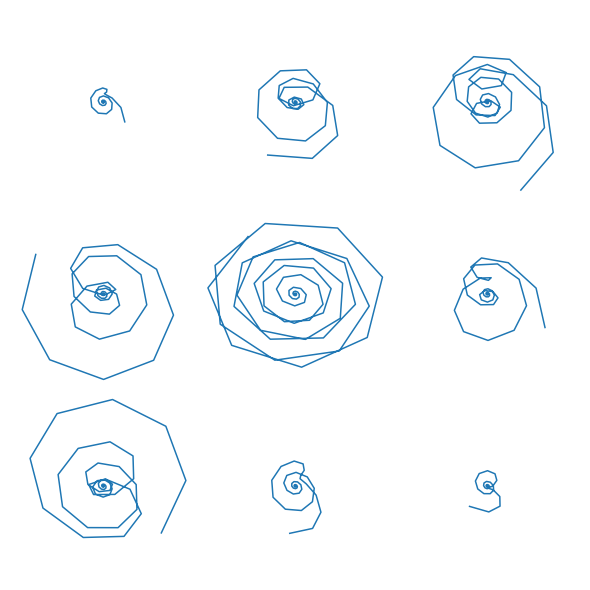

In [30]:
n_res = min(len(res),80)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(res):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['state'][:,1],res_i['state'][:,0])
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
    
fig.tight_layout(pad=0)